In [56]:
import numpy as np
#
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'family':'Times New Roman', 'weight':'normal', 'size':10})
import matplotlib.pyplot as plt

In [57]:
ng = 4   # the number of checks along a dimension
t = np.linspace(0,1,ng+1)

In [58]:
X = np.random.uniform(0,1,size=(1000,2))

In [59]:
Y = np.sum(np.floor(X*ng),axis=1) % 2
Y = np.vstack([Y, 1.-Y]).T   # have 2-dimensions for cross-entropy in neural net

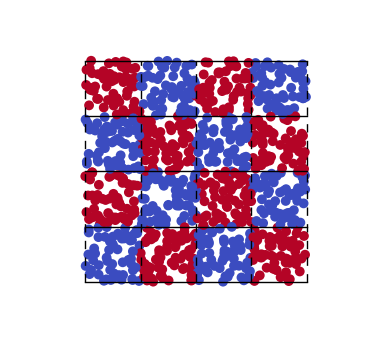

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(4,4)
for s in t:
    plt.plot(s*np.ones_like(t),t,color='black',linestyle='--',linewidth=1.)
    plt.plot(t,s*np.ones_like(t),color='black',linestyle='-',linewidth=1.)
plt.scatter(X[:,0],X[:,1],s=50,c=Y[:,0],edgecolors='',cmap=plt.cm.coolwarm)
plt.axis('equal')
plt.axis('off')
plt.show()

In [61]:
import tensorflow as tf

In [62]:
def fc_layer(incoming, size_in, size_out, name="fc"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        act = tf.nn.relu(tf.matmul(incoming, w) + b)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return act

In [63]:
tf.reset_default_graph()
sess = tf.Session()

In [64]:
# Setup placeholders, and reshape the data
x = tf.placeholder(tf.float32, shape=[None, 2], name="x")
y = tf.placeholder(tf.float32, shape=[None, 2], name="labels")

In [65]:
fc1 = fc_layer(x, 2, 64, 'fc1')
fc2 = fc_layer(fc1, 64, 64, 'fc2')
fc3 = fc_layer(fc2, 64, 64, 'fc3')
logits = fc_layer(fc3, 64, 2, 'fc4')

In [84]:
with tf.name_scope("xent"):
    xent = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=logits, labels=y), name="xent")
    tf.summary.scalar("xent", xent)
    
with tf.name_scope("train"):
    learning_rate = 1.e-3
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(xent)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy)

summ = tf.summary.merge_all()    

In [85]:
saver = tf.train.Saver()

In [86]:
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter('/tmp/checkerboard/1')
writer.add_graph(sess.graph)

In [87]:
import os

In [88]:
num_steps = 10000
batch_size = 128
for step in range(num_steps):
    offset = (step * batch_size) % X.shape[0]
    # Generate a minibatch.
    batch_data = X[offset:(offset + batch_size), :]
    batch_labels = Y[offset:(offset + batch_size), :]
    if step % 5 == 0:
        [train_accuracy, s] = sess.run([accuracy, summ], feed_dict={x: batch_data, y: batch_labels})
        writer.add_summary(s, step)        
    if step % 500 == 0:
        print("Minibatch accuracy: %.2f" % train_accuracy)
        saver.save(sess, os.path.join('/tmp/checkerboard', "model.ckpt"), step)
    sess.run(train_step, feed_dict={x: batch_data, y: batch_labels})

Minibatch accuracy: 0.46
Minibatch accuracy: 0.69
Minibatch accuracy: 0.74
Minibatch accuracy: 0.87
Minibatch accuracy: 0.90
Minibatch accuracy: 0.95
Minibatch accuracy: 0.96
Minibatch accuracy: 0.98
Minibatch accuracy: 0.92
Minibatch accuracy: 0.98
Minibatch accuracy: 0.98
Minibatch accuracy: 0.95
Minibatch accuracy: 0.98
Minibatch accuracy: 0.97
Minibatch accuracy: 0.98
Minibatch accuracy: 0.98
Minibatch accuracy: 0.98
Minibatch accuracy: 0.97
Minibatch accuracy: 0.96
Minibatch accuracy: 0.96


In [89]:
decision_values, predicted = sess.run([logits, tf.nn.softmax(logits)], feed_dict={x: X})

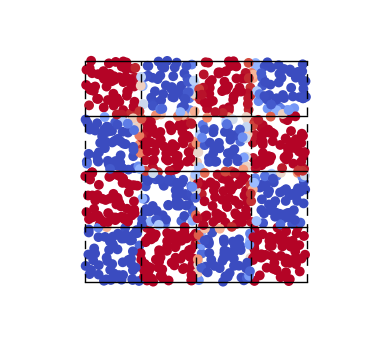

In [90]:
fig, ax = plt.subplots()
fig.set_size_inches(4,4)
for s in t:
    plt.plot(s*np.ones_like(t),t,color='black',linestyle='--',linewidth=1.)
    plt.plot(t,s*np.ones_like(t),color='black',linestyle='-',linewidth=1.)
plt.scatter(X[:,0],X[:,1],s=50,c=predicted[:,0],edgecolors='',cmap=plt.cm.coolwarm)
plt.axis('equal')
plt.axis('off')
plt.show()